In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from src.utils_clustering_v2 import load_labels_from_file, map_clusters_to_ground_truth, evaluate_clustering, generate_confusion_matrix

# Ignore all warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from src.data_preprocessing import preprocess_data

[1/1] unbalance


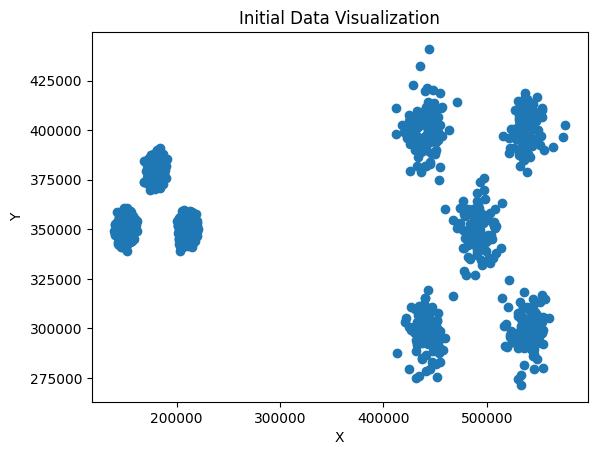

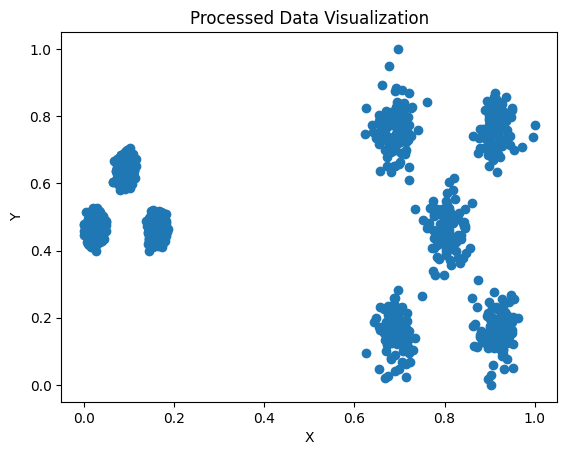

In [3]:
import os

n_iter = 60

VERSION = '0.1.3'

DATASET_DIR = 'unbalance'

# Specify the directory path you want to list files from
directory_path = f'../data/raw/{DATASET_DIR}'

# Get a list of all files in the directory (excluding directories)
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
total_files = len(files)

# List all files in the specified directory
for index, filename in enumerate(files, start=1):
    if os.path.isfile(os.path.join(directory_path, filename)):
        print(f"[{index}/{total_files}] {filename.split('.')[0]}")


        FILE_NAME = filename.split('.')[0]
        file_path = rf'..\data\raw\{DATASET_DIR}\{FILE_NAME}.txt'

        # The regular expression '\s+' can be used to match one or more spaces
        data = pd.read_csv(file_path, sep="\s+", header=None, names=['X', 'Y'])
        # Check the first few rows of your DataFrame
        data.head()
        # Check for NaN or missing values
        data.isna().sum()
        data.shape
        # Remove rows with missing values:
        data_clean = data.dropna()

        # Replace missing values (e.g., with the mean):
        # data_clean = data.fillna(data.mean())
        data.shape
        plt.scatter(data_clean['X'], data_clean['Y'])
        plt.title('Initial Data Visualization')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
        processed_data = preprocess_data(data)
        processed_data.head()
        plt.scatter(processed_data['X'], processed_data['Y'])
        plt.title('Processed Data Visualization')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

        # Ensure the processed data directory exists
        processed_directory_path = rf'../data/processed/{DATASET_DIR}'
        os.makedirs(processed_directory_path, exist_ok=True)  # This creates the directory if it does not exist

        # Save the processed data to a CSV file
        processed_data_path = rf'..\data\processed\{DATASET_DIR}\{FILE_NAME}.txt'
        processed_data.to_csv(processed_data_path, index=False)
        processed_data_path


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from src.utils_clustering_v2 import load_labels_from_file, map_clusters_to_ground_truth, evaluate_clustering, \
    generate_confusion_matrix

# Specify the directory path you want to list files from
directory_path = f'../data/raw/{DATASET_DIR}'

# Get a list of all files in the directory (excluding directories)
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
total_files = len(files)

# List all files in the specified directory
for index, filename in enumerate(files, start=1):
    if os.path.isfile(os.path.join(directory_path, filename)):
        print(f"[{index}/{total_files}] {filename.split('.')[0]}")
        DATASET_FILE_NAME = filename.split('.')[0]
        LABELS_FILE_NAME = f'{DATASET_FILE_NAME}-gt.pa'
        labels_true = load_labels_from_file(rf'..\data\label\{DATASET_DIR}\{LABELS_FILE_NAME}', 15)
        N_CLUSTERS = len(set(labels_true))
        
        warnings.filterwarnings("ignore")
        file_path = rf'..\data\processed\{DATASET_DIR}\{DATASET_FILE_NAME}.txt'
        processed_data = pd.read_csv(file_path)

        
        clustering_algorithm_name = 'KMeans_clustering'
        dataset_name = DATASET_FILE_NAME
        # Evaluating Clustering Algorithm with Train, Validation, and Test Sets
        
        # Split the data into train and temp (temp will contain both validate and test)
        train_data, temp_data, train_labels, temp_labels = train_test_split(
            processed_data, labels_true, train_size=0.5, random_state=42)
        
        # Split the temp data into validate and test
        validate_data, test_data, validate_labels, test_labels = train_test_split(
            temp_data, temp_labels, train_size=0.5, random_state=42)
        
        # You now have train_data, validate_data, and test_data
        # print(f"Train set size: {len(train_data)}")
        # print(f"Validate set size: {len(validate_data)}")
        # print(f"Test set size: {len(test_data)}")
        
        hyperparameter_domains = {
            'n_clusters': [N_CLUSTERS],
            'init': ['k-means++', 'random'],
            'n_init': np.arange(5, 100, 5),
            'max_iter': [100, 300, 1000, 2000, 5000, 10000, 20000, 40000, 60000, 80000],
            'algorithm': ['auto', 'elkan', 'full']
        }
        
        from sklearn.cluster import KMeans
        import time
        from sklearn.model_selection import ParameterSampler
        
        
        def calculate_grid_size(space):
            # For each parameter, count the number of unique values and multiply them
            return np.prod([len(values) for values in space.values()])
        
        
        grid_size = calculate_grid_size(hyperparameter_domains)
        # print(f"{clustering_algorithm_name} hyperparameter grid size: {grid_size}")
        results_path = rf'../results/metrics/results_kmeans_{DATASET_FILE_NAME}_v{VERSION}.csv'
        
        # Sample configurations
        
        parameter_sampler = ParameterSampler(hyperparameter_domains, n_iter=n_iter, random_state=42)
        
        # Debugging: Print the number of configurations to run
        # print(f"Total configurations to run: {n_iter}")
        
        # Run clustering for each configuration
        for i, params in enumerate(parameter_sampler, start=1):
            # print(f"Running configuration {i}/{n_iter}: {params}")  # Debugging: print before running
            start_time = time.time()
        
            # Initialize and fit KMeans
            kmeans_clustering = KMeans(**params, random_state=42)
        
            # Start timing the training phase
            training_start_time = time.time()
        
            # Fit KMeans using only the training data
            kmeans_clustering.fit(train_data)
        
            # End timing the training phase
            training_end_time = time.time()
            training_time = (training_end_time - training_start_time)
        
            # Start timing the prediction phase
            prediction_start_time = time.time()
        
            # Predict labels for the validation or test data
            labels_pred = kmeans_clustering.predict(validate_data)
        
            # End timing the prediction phase
            prediction_end_time = time.time()
            prediction_time = (prediction_end_time - prediction_start_time)
        
            algorithm_params = kmeans_clustering.get_params()
            algorithm_details = str(algorithm_params)
        
            labels_pred = map_clusters_to_ground_truth(validate_labels, labels_pred)
            evaluate_clustering(X=validate_data, labels_true=validate_labels, labels_pred=labels_pred,
                                clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                                results_path=results_path, algorithm_details=algorithm_details,
                                training_time=training_time, prediction_time=prediction_time)
            # generate_confusion_matrix(labels_true, labels_pred, N_CLUSTERS)
        FILE_NAME = f'results_kmeans_{DATASET_FILE_NAME}_v{VERSION}.csv'
        file_path = rf'..\results\metrics\{FILE_NAME}'
        csv_content = pd.read_csv(file_path)
        
        # Find the record with the highest accuracy
        max_accuracy_record = csv_content.loc[csv_content['Accuracy'].idxmax()]
        
        # Display the record with the highest accuracy
        # print(max_accuracy_record)
        print(max_accuracy_record['Algorithm Details'])
        print(max_accuracy_record['Accuracy'],"\n")
        results_path = rf'../results/metrics/results_kmeans_final_{DATASET_FILE_NAME}_v{VERSION}.csv'
        
        combined_train_data = pd.concat([train_data, validate_data])
        combined_train_labels = np.concatenate([train_labels, validate_labels])
        
        # Initialize KMeans with the best hyperparameters
        best_params = max_accuracy_record['Algorithm Details']  # Assume this contains the best parameters
        kmeans_final = KMeans(**eval(best_params))
        
        # Start timing the training phase
        training_start_time = time.time()
        
        # Retrain using the combined dataset
        kmeans_final.fit(combined_train_data)
        
        # End timing the training phase
        training_end_time = time.time()
        training_time = (training_end_time - training_start_time)
        
        # Start timing the prediction phase
        prediction_start_time = time.time()
        
        # Predict on the test set
        final_labels_pred = kmeans_final.predict(test_data)
        
        # End timing the prediction phase
        prediction_end_time = time.time()
        prediction_time = (prediction_end_time - prediction_start_time)
        
        algorithm_params = kmeans_final.get_params()
        algorithm_details = str(algorithm_params)
        
        # Map predicted labels to ground truth labels for the test set
        final_labels_pred = map_clusters_to_ground_truth(test_labels, final_labels_pred)
        # generate_confusion_matrix(test_labels, final_labels_pred, N_CLUSTERS)
        
        evaluate_clustering(X=test_data, labels_true=test_labels, labels_pred=final_labels_pred,
                            clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                            results_path=results_path, algorithm_details=algorithm_details,
                            training_time=training_time, prediction_time=prediction_time)

[1/1] unbalance
{'algorithm': 'full', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 8, 'n_init': 95, 'random_state': 42, 'tol': 0.0001, 'verbose': 0}
1.0 
